# Speed up data loading
As I started working on an UNet baseline, I found the speed to be extremely slow. I realized the bottleneck is not the models but rather the I/O. It takes a very long time to read a tiff file. So it seemed a good idea to think about alternative formats to save the data in. `.npy` is always a great option in these scenarios. But first I wanted to compare a few file formats on the basis of loading speed and file size.

The files saved from this notebook in `train_images_npy` and `train_images_rle` can directly be used for a faster training experience. To load the `RLE` encoded labels, use the `load_rle` function from the notebook.

In actual training epoch, this data is giving about ~8-10x speedup.

In [1]:
!pip install -q imagecodecs zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 90.1 MB/s eta 0:00:00


In [2]:
import os
from pathlib import Path
import numpy as np
import tifffile as tiff
from tqdm import tqdm
import zarr
import time
from concurrent.futures import ProcessPoolExecutor


DATA_DIR = Path("/kaggle/input/vesuvius-challenge-surface-detection")
IMG_DIR = DATA_DIR / "train_images"
LBL_DIR = DATA_DIR / "train_labels"

In [3]:
# -----------------------------
# File I/O functions
# -----------------------------

def save_npy(array, path):
    np.save(path, array.astype(np.uint8))

def save_npz(array, path):
    np.savez_compressed(path, array.astype(np.uint8))

def save_zarr(array, path):
    z = zarr.open(str(path), mode='w', shape=array.shape, chunks=(64,64,64), dtype=array.dtype)
    z[:] = array.astype(np.uint8)

def rle_encode_3d(mask):
    """
    mask: 3D numpy array of int/uint8
    Returns: dict with 'shape', 'vals', 'runs'
    """
    flat = mask.ravel()

    # Where values change
    changes = np.where(np.diff(flat) != 0)[0] + 1

    # Start positions of each run
    starts = np.concatenate(([0], changes))

    # Run lengths
    ends = np.concatenate((changes, [len(flat)]))
    runs = ends - starts

    # Correct values at each run start
    vals = flat[starts]

    return {
        "shape": mask.shape,
        "vals": vals.astype(np.uint8),
        "runs": runs.astype(np.uint32),
    }

def save_rle(mask, path):
    """
    Saves RLE to .npz
    """
    rle = rle_encode_3d(mask)
    np.savez_compressed(
        path,
        shape=np.array(rle["shape"], dtype=np.int32),
        vals=rle["vals"],
        runs=rle["runs"],
    )

def load_rle(path):
    rle = np.load(path)
    shape = tuple(rle["shape"])
    vals = rle["vals"]
    runs = rle["runs"]
    flat = np.repeat(vals, runs)
    return flat.reshape(shape)

def load_array(path, fmt):
    if fmt == "tiff":
        return tiff.imread(path)
    elif fmt == "npy":
        return np.load(path)
    elif fmt == "npz":
        return np.load(path)["arr_0"]
    elif fmt == "zarr":
        return zarr.open(str(path), mode='r')[:]
    elif fmt == "rle":
        return load_rle(path)
    else:
        raise ValueError(fmt)

In [4]:
formats = ["tiff", "npy", "npz", "zarr"]

IMG_LIST = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".tif")])[:10]
OUT_DIR = Path("/kaggle/working/format_test_images")
OUT_DIR.mkdir(exist_ok=True)

# -----------------------------
# Step 1: Save all formats
# -----------------------------
print(f"Saving files in different formats... {formats}")
for i, f in enumerate(IMG_LIST):
    tiff_path = IMG_DIR / f
    array = tiff.imread(tiff_path)

    save_npy(array, OUT_DIR / f"{i}_npy.npy")
    save_npz(array, OUT_DIR / f"{i}_npz.npz")
    save_zarr(array, OUT_DIR / f"{i}_zarr.zarr")

# -----------------------------
# Step 2: Compare sizes
# -----------------------------
file_sizes = {}

for fmt in formats:
    if fmt == "tiff":
        total_size = sum((IMG_DIR / f).stat().st_size for f in IMG_LIST)
    else:
        total_size = sum(
            (OUT_DIR / f).stat().st_size if (OUT_DIR / f).is_file() 
            else sum(p.stat().st_size for p in (OUT_DIR / f).rglob("*")) 
            for f in os.listdir(OUT_DIR) if fmt in f
        )
    file_sizes[fmt] = total_size / 10e6

# -----------------------------
# Step 3: Load timing
# -----------------------------
print("Calculating load times per format...\n")
timings = {fmt: [] for fmt in formats}

for fmt in formats:
    if fmt == "tiff":
        files = [IMG_DIR / f for f in IMG_LIST]
    else:
        files = [OUT_DIR / f for f in os.listdir(OUT_DIR) if fmt in f]
        
    for _ in range(5):
        start = time.time()
        for f in files:
            arr = load_array(f, fmt)
            assert isinstance(arr, np.ndarray)
        timings[fmt].append(time.time() - start)

load_times = {fmt: float(np.mean(timings[fmt])) for fmt in formats}

# -----------------------------
# Step 4: Display results in a table
# -----------------------------
import pandas as pd

df = pd.DataFrame({
    "Format": formats,
    "Avg File Size (MB)": [file_sizes[f] for f in formats],
    "Avg Load Time (sec)": [load_times[f] for f in formats],
})

df

Saving files in different formats... ['tiff', 'npy', 'npz', 'zarr']
Calculating load times per format...



,Format,Avg File Size (MB),Avg Load Time (sec)
0,tiff,34.339006,2.768405
1,npy,32.768128,0.085461
2,npz,27.502153,2.599957
3,zarr,27.672553,1.262067


So `.npy` is clearly the best choice for the image files. It's ~25x faster for loading. The size is also similar to the tiff file.

In [5]:
formats = ["tiff", "npy", "zarr", "rle"]

LBL_LIST = sorted([f for f in os.listdir(LBL_DIR) if f.endswith(".tif")])[:10]
OUT_DIR = Path("/kaggle/working/format_test_labels")
OUT_DIR.mkdir(exist_ok=True)

# -----------------------------
# Step 1: Save all formats
# -----------------------------
print(f"Saving files in different formats... {formats}")
for i, f in enumerate(LBL_LIST):
    tiff_path = LBL_DIR / f
    array = tiff.imread(tiff_path)

    save_npy(array, OUT_DIR / f"{i}_npy.npy")
    save_npz(array, OUT_DIR / f"{i}_npz.npz")
    save_zarr(array, OUT_DIR / f"{i}_zarr.zarr")
    save_rle(array, OUT_DIR / f"{i}_rle.npz")

# -----------------------------
# Step 2: Compare sizes
# -----------------------------
file_sizes = {}

for fmt in formats:
    if fmt == "tiff":
        total_size = sum((LBL_DIR / f).stat().st_size for f in LBL_LIST)
    else:
        total_size = sum(
            (OUT_DIR / f).stat().st_size if (OUT_DIR / f).is_file() 
            else sum(p.stat().st_size for p in (OUT_DIR / f).rglob("*")) 
            for f in os.listdir(OUT_DIR) if fmt in f
        )
    file_sizes[fmt] = total_size / 10e6

# -----------------------------
# Step 3: Load timing including original TIFFs
# -----------------------------
print("Calculating load times per format...\n")
timings = {fmt: [] for fmt in formats}

for fmt in formats:
    if fmt == "tiff":
        files = [LBL_DIR / f for f in LBL_LIST]
    else:
        files = [OUT_DIR / f for f in os.listdir(OUT_DIR) if fmt in f]
        
    for _ in range(5):
        start = time.time()
        for f in files:
            arr = load_array(f, fmt)
        timings[fmt].append(time.time() - start)

load_times = {fmt: float(np.mean(timings[fmt])) for fmt in formats}

# -----------------------------
# Step 4: Display results in a table
# -----------------------------
import pandas as pd

df = pd.DataFrame({
    "Format": formats,
    "Avg File Size (MB)": [file_sizes[f] for f in formats],
    "Avg Load Time (sec)": [load_times[f] for f in formats],
})

df

Saving files in different formats... ['tiff', 'npy', 'zarr', 'rle']
Calculating load times per format...



,Format,Avg File Size (MB),Avg Load Time (sec)
0,tiff,1.338534,0.885683
1,npy,32.768128,0.089306
2,zarr,0.933277,1.059811
3,rle,0.807366,0.492835


`.npy` is again the best here in terms of speed. But it is very inefficient in terms of memory. Most of the info contained in a label mask should not take up that much data. So I choose RLE (Run Length Encoding) format as it provides the best of both worlds.

In [6]:
!rm -rf /kaggle/working/*

# Resize images and labels to 256x256x256 and save
To save a bit more space and shave off a few more miliseconds, we will downsample the images and masks to 256x256x256. It will have a negligible impact on quality but cut down the file size to half.

In [7]:
NPY_IMG_DIR = Path("/kaggle/working/train_images_npy")
NPY_LBL_DIR = Path("/kaggle/working/train_labels_rle")
NPY_IMG_DIR.mkdir(exist_ok=True)
NPY_LBL_DIR.mkdir(exist_ok=True)

import numpy as np
from pathlib import Path
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import tifffile as tiff
from scipy.ndimage import zoom

# -----------------------------
# Single file processing
# -----------------------------
def process_file(args, file_type="image"):
    tiff_path, npy_dir, target_shape = args
    array = tiff.imread(tiff_path)
    factors = [t / s for t, s in zip(target_shape, array.shape)]

    if file_type == "image":
        array_ds = zoom(array, factors, order=1).astype(np.uint8)
        npy_path = NPY_IMG_DIR / (tiff_path.stem + ".npy")
        save_npy(array_ds, npy_path)
    else:
        array_ds = np.round(zoom(array, factors, order=1)).astype(np.uint8)
        rle_path = Path(npy_dir) / (tiff_path.stem + ".npz")
        save_rle(array_ds, rle_path)

# -----------------------------
# Parallel processing
# -----------------------------
def preprocess_and_save_tiffs_parallel(tiff_dir, npy_dir, file_type="image", target_shape=(256,256,256), max_workers=4):
    tiff_dir = Path(tiff_dir)
    npy_dir = Path(npy_dir)
    npy_dir.mkdir(exist_ok=True)

    files = sorted([f for f in os.listdir(tiff_dir) if f.endswith(".tif")])
    paths = [(tiff_dir / f, npy_dir, target_shape) for f in files]

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(process_file, paths, [file_type for _ in paths]), total=len(paths)))


preprocess_and_save_tiffs_parallel(LBL_DIR, NPY_LBL_DIR, file_type="label", target_shape=(256,256,256), max_workers=8)
preprocess_and_save_tiffs_parallel(IMG_DIR, NPY_IMG_DIR, file_type="image", target_shape=(256,256,256), max_workers=8)

print("Conversion completed!")

100%|██████████| 806/806 [10:45<00:00,  1.25it/s]

Conversion completed!


# Comparing original and processed images and labels
Let's verify some before and after results

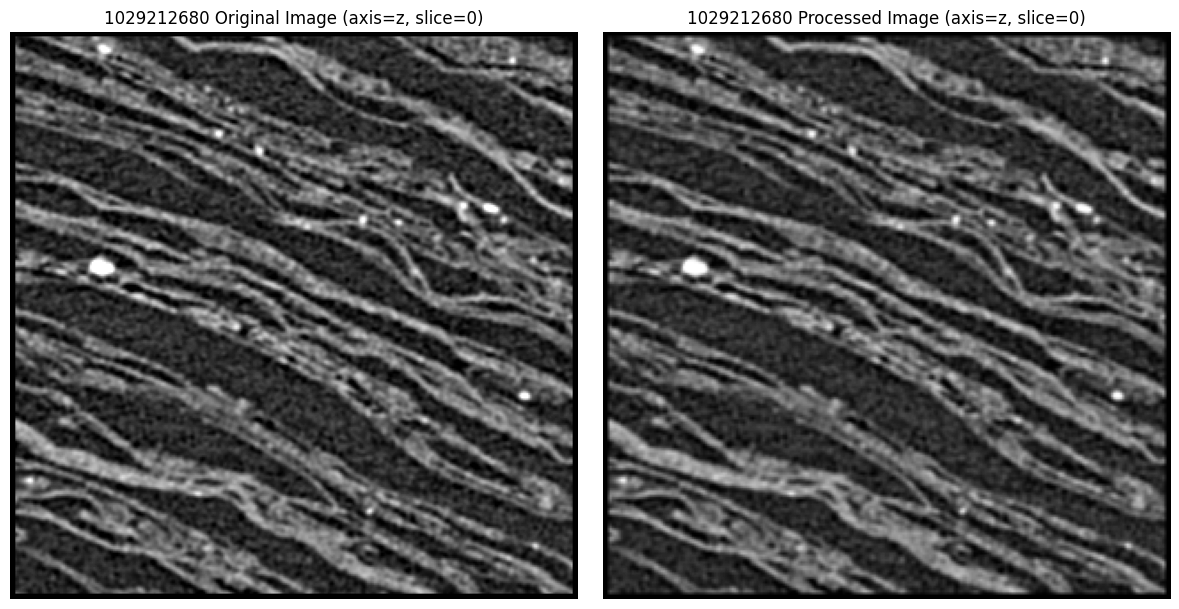

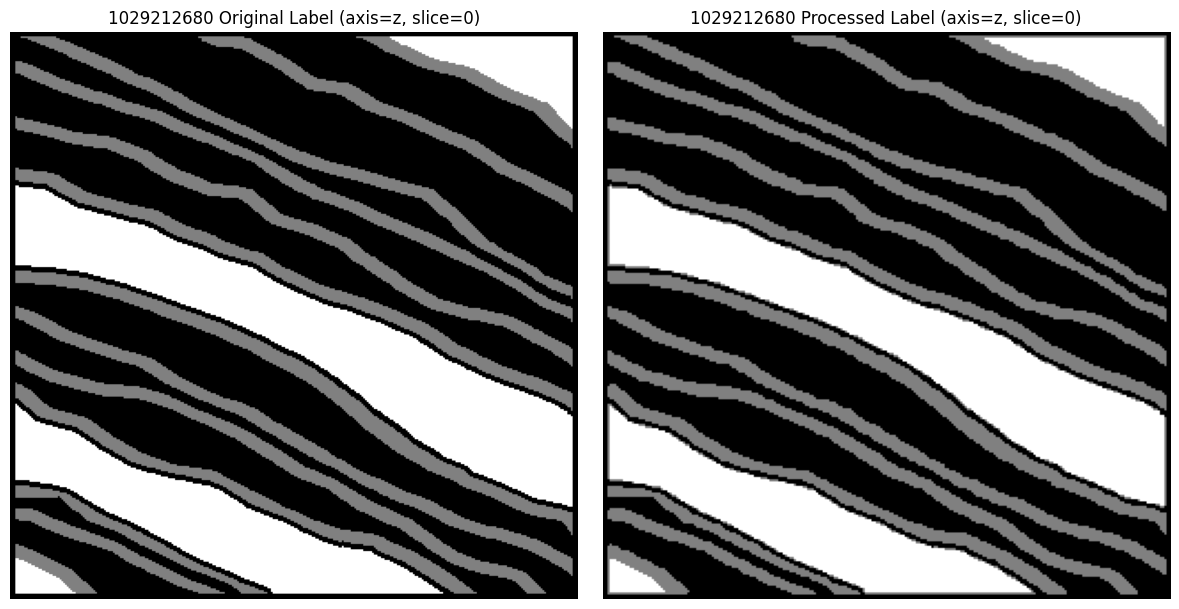

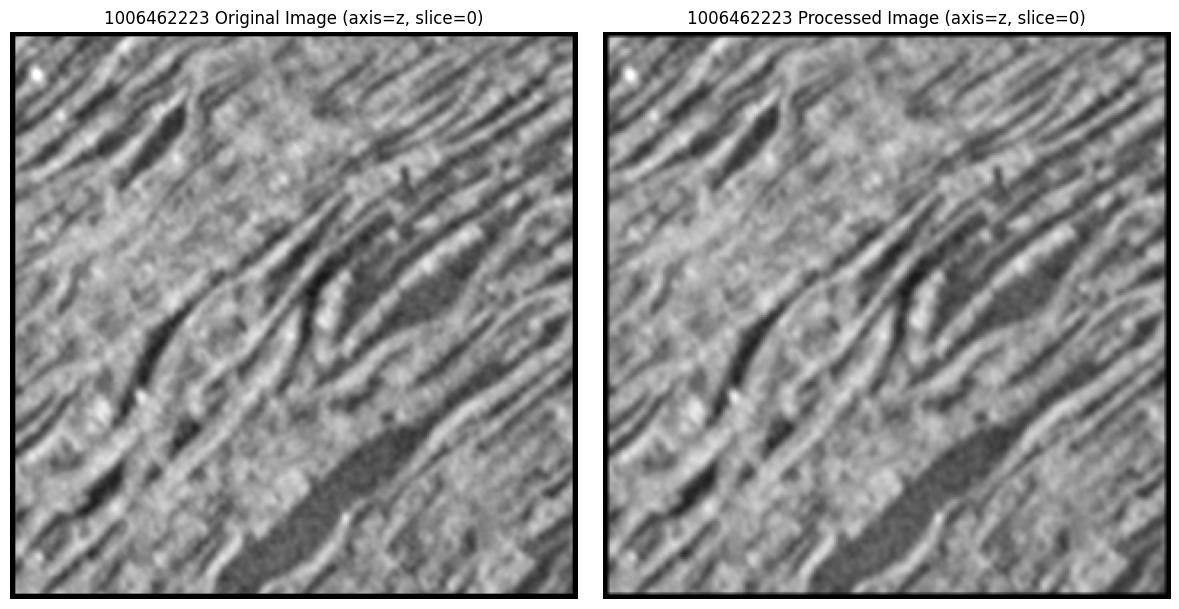

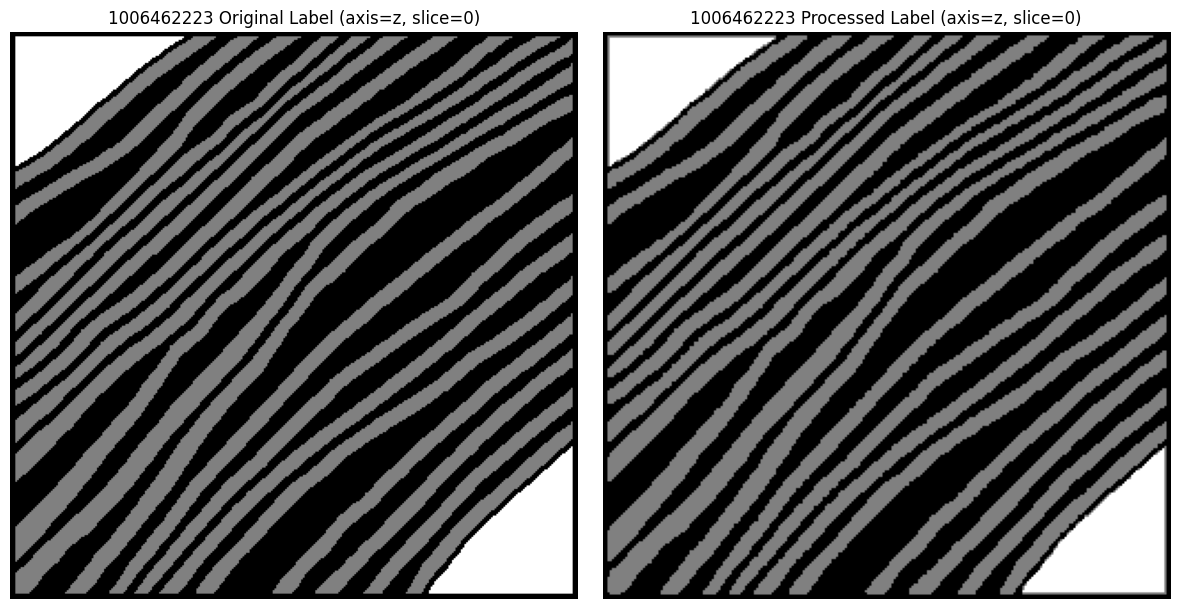

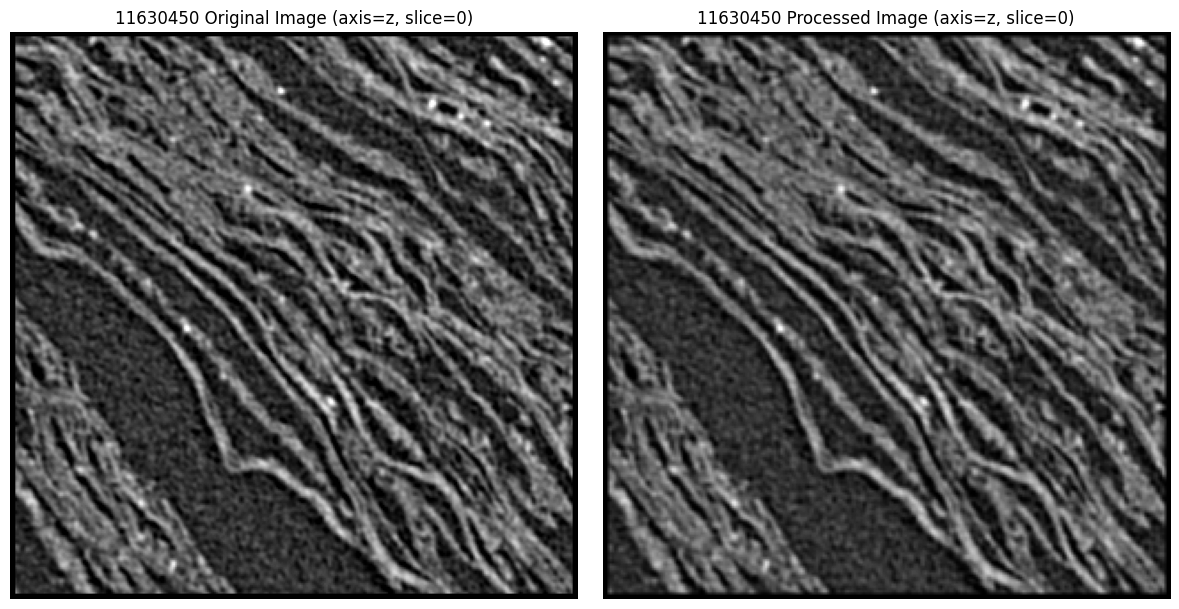

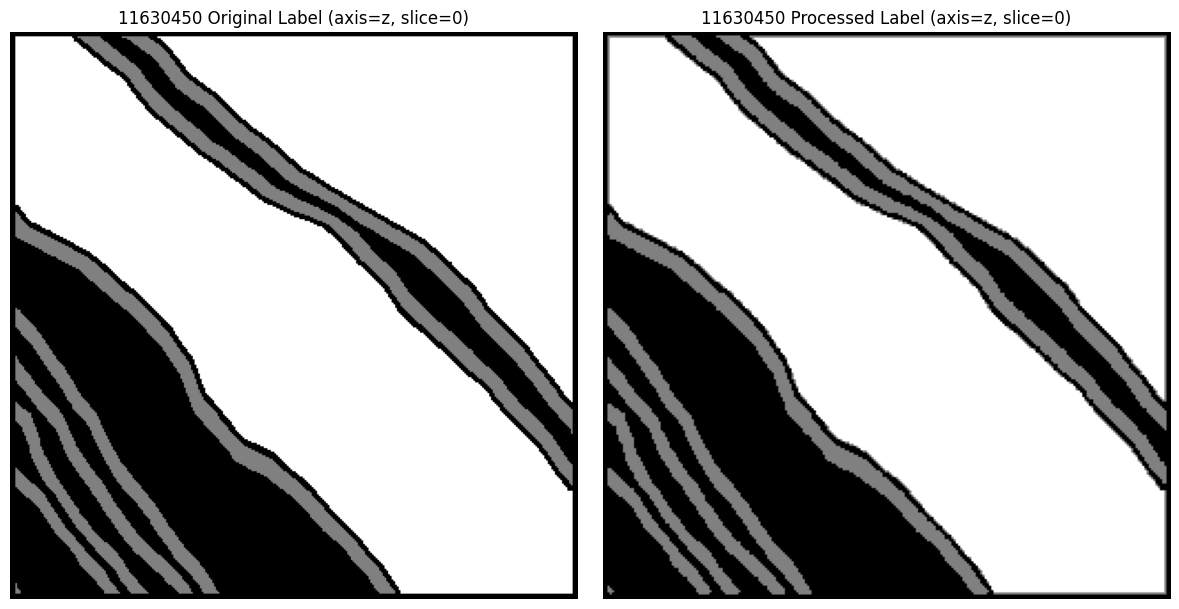

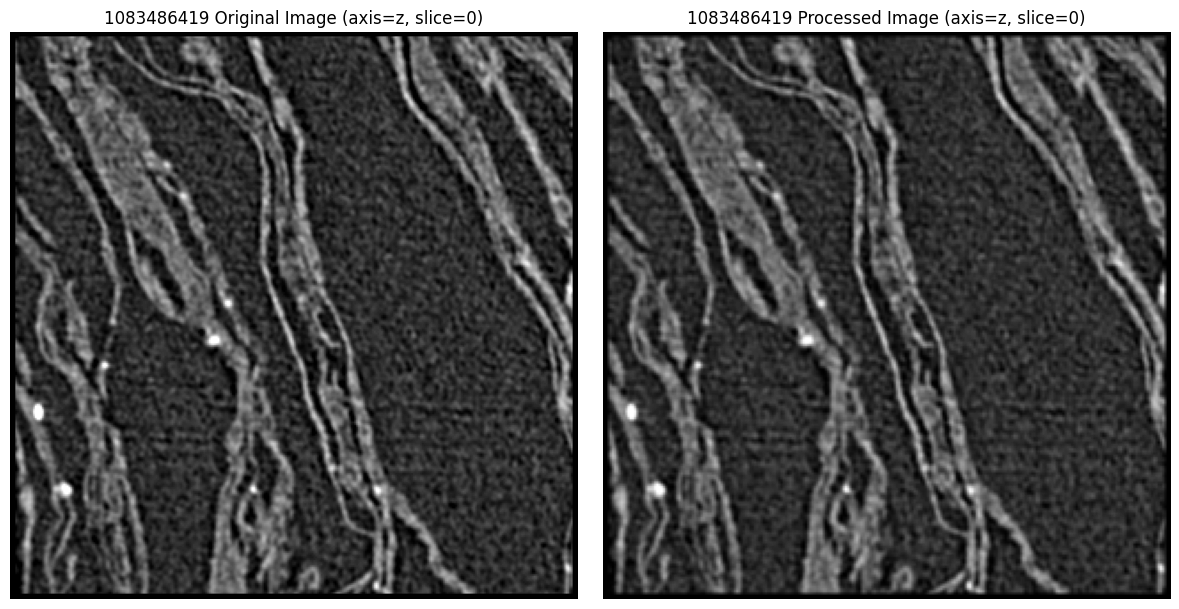

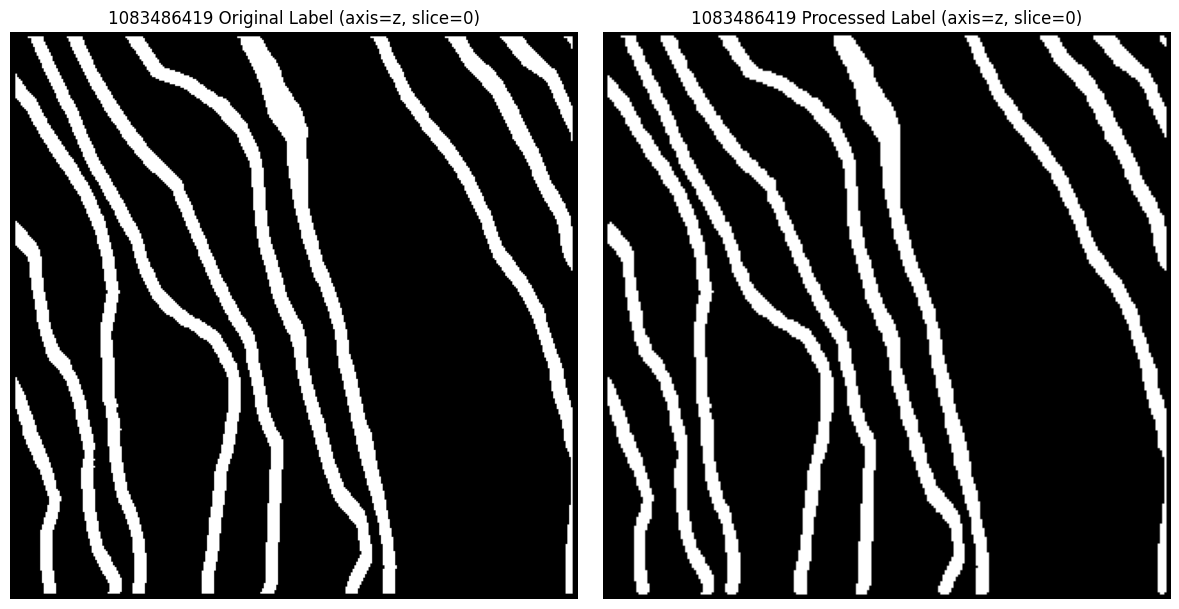

In [8]:
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
from pathlib import Path

def show_comparison(file_ids, orig_img_dir, orig_lbl_dir, proc_img_dir, proc_lbl_dir,
                    axis="z", slice_indices=None, max_files=5):
    """
    Compare original and processed images/labels side by side.
    """
    file_ids = file_ids[:max_files]

    for fid in file_ids:
        # Load original
        orig_img = tiff.imread(Path(orig_img_dir) / f"{fid}.tif")
        orig_lbl = tiff.imread(Path(orig_lbl_dir) / f"{fid}.tif")

        # Load processed
        proc_img = np.load(Path(proc_img_dir) / f"{fid}.npy")
        proc_lbl = load_rle(Path(proc_lbl_dir) / f"{fid}.npz")

        for idx in range(1):
            def get_slice(arr):
                if axis=="z":
                    return arr[arr.shape[0]//2, ...]
                elif axis=="y":
                    return arr[:, arr.shape[1]//2, :]
                elif axis=="x":
                    return arr[:, :, arr.shape[2]//2]
                else:
                    raise ValueError("axis must be 'x', 'y', or 'z'")

            slices = {
                "orig_img": get_slice(orig_img),
                "proc_img": get_slice(proc_img),
                "orig_lbl": get_slice(orig_lbl),
                "proc_lbl": get_slice(proc_lbl)
            }

            # Plot side by side
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.title(f"{fid} Original Image (axis={axis}, slice={idx})")
            plt.imshow(slices["orig_img"], cmap="gray")
            plt.axis("off")

            plt.subplot(1,2,2)
            plt.title(f"{fid} Processed Image (axis={axis}, slice={idx})")
            plt.imshow(slices["proc_img"], cmap="gray")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

            # Labels comparison
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.title(f"{fid} Original Label (axis={axis}, slice={idx})")
            plt.imshow(slices["orig_lbl"], cmap="gray")
            plt.axis("off")

            plt.subplot(1,2,2)
            plt.title(f"{fid} Processed Label (axis={axis}, slice={idx})")
            plt.imshow(slices["proc_lbl"], cmap="gray")
            plt.axis("off")
            plt.tight_layout()
            plt.show()


file_ids = ["1029212680", "1006462223", "11630450", "1083486419"]
show_comparison(file_ids,
                orig_img_dir=IMG_DIR,
                orig_lbl_dir=LBL_DIR,
                proc_img_dir=NPY_IMG_DIR,
                proc_lbl_dir=NPY_LBL_DIR,
                axis="z",
                slice_indices=None,
                max_files=5)